<a href="https://colab.research.google.com/github/guilhermelaviola/ApplicationsOfDataScienceInDisruptiveTechnologies/blob/main/Class11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CAMShift (Continuously Adaptive Meanshift)**
CAMShift, an advancement of the Meanshift algorithm, excels in object tracking within dynamic videos by continuously adjusting the tracking window's size to account for changes in scale, direction, and shape of moving objects. This adaptability makes it particularly effective in scenarios like sports, surveillance, and autonomous vehicles, where objects frequently move in and out of frame. Unlike Meanshift's fixed-size window, CAMShift recalibrates with each frame, enhancing accuracy in tracking objects, such as a soccer player whose movement varies greatly. The algorithm also employs the HSV color space for improved color detection under varying lighting conditions, and it can be combined with the Kalman Filter to maintain tracking when objects become temporarily obscured. Key implementation aspects include using computer vision libraries like OpenCV and applying techniques such as smoothing filters and initial region of interest (ROI) definition. Overall, CAMShift is recognized for its robustness and versatility across various applications, including security systems and motion analysis in sports and robotics.

In [1]:
# Importing all the necessary libraries:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow

Saving live-to-tell.mp4 to live-to-tell.mp4


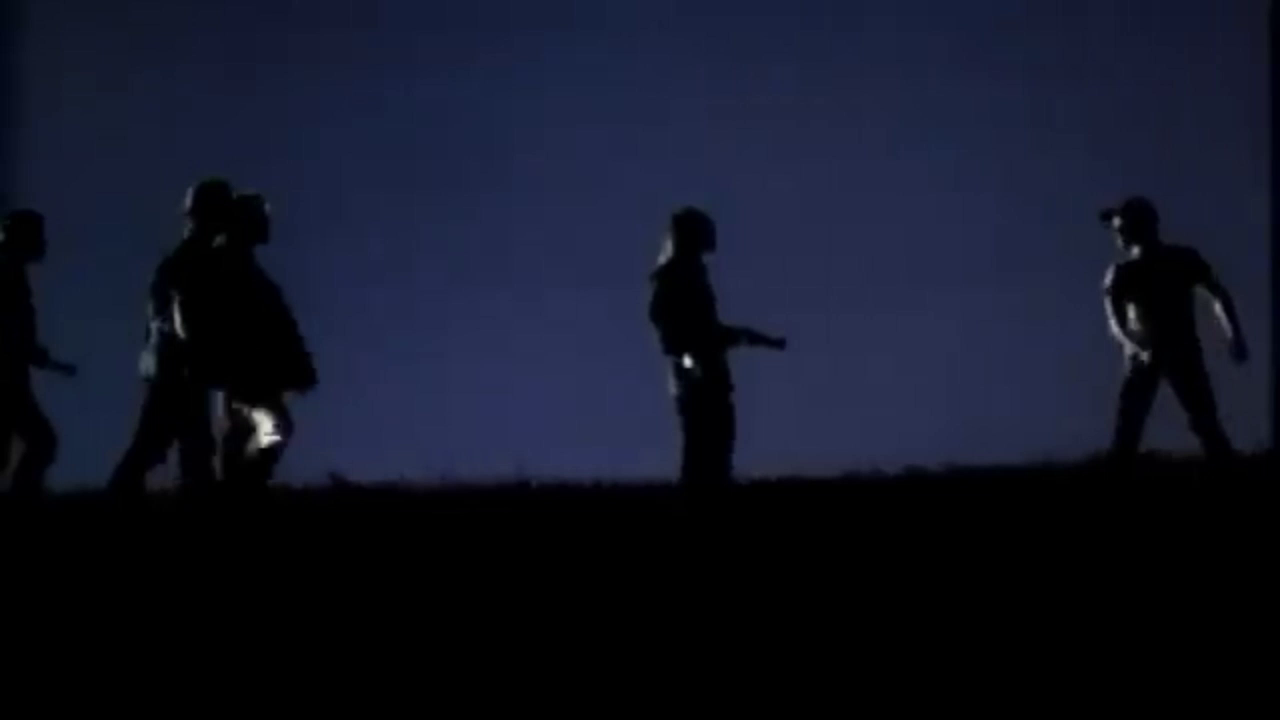

No contour found. ROI not defined.


In [2]:
# Function to upload the video:
uploaded = files.upload()
video_filename = list(uploaded.keys())[0]  # Getting the name of the uploaded file.

# Loading the user video:
cap = cv2.VideoCapture(video_filename)
# Checking if the video was properly loaded:
if not cap.isOpened():
    print('Error opening the video.')
else:
    # Capturing the first frame to define the ROI:
    ret, frame = cap.read()
    if ret:
        # Displaying the first frame:
        cv2_imshow(frame)
        # Converting the image to the HSV color space:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        # Defining the color range for detection (green as an example):
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        # Creating a mask to identify the green color:
        mask = cv2.inRange(hsv, lower_green, upper_green)
        # Finding contours in the mask:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # If contours found, defines the ROI based on the biggers contour:
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            roi = (x, y, w, h)
            roi_hist = cv2.calcHist([frame[y:y+h, x:x+w]], [0, 1], None, [256, 256], [0, 180, 0, 256])
            cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
        else:
            print('No contour found. ROI not defined.')
            cap.release()
            exit()
    else:
        print('Error reading the first frame of the video.')

# List to store the resulting frames:
output_frames = []

# Loop to track the video object:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Converting to HSV color space:
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Calculating the probability of the new position:
    back_project = cv2.calcBackProject([hsv], [0, 1], roi_hist, [0, 180, 0, 256], 1)

    # Applying the CAMShift:
    ret_val = cv2.CamShift(back_project, roi, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))

    # Deconstructing the return of CamShift:
    if ret_val is not None:
        # The return value is a tuple containing the tracking box and the new ROI:
        rotated_rect, track_window = ret_val

        # Drawing the tracking box:
        pts = cv2.boxPoints(rotated_rect)  # Using a RotatedRect directly:
        pts = np.int0(pts)
        cv2.polylines(frame, [pts], True, (255, 0, 0), 2)

    # Adding the resulting frame to the list:
    output_frames.append(frame)

# Releasing the video:
cap.release()

# Displaying all resulting frames at the end:
for output_frame in output_frames:
    cv2_imshow(output_frame)